In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset
import torchmetrics
import numpy as np
import stumpy
from torch.utils.data.dataset import random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as  sns
from transphorm.framework_helpers.sk_helpers import *
from matplotlib.patches import Rectangle
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]='1'

### Imports

In [ ]:
main_path = Path('/Users/mds8301/Desktop/temp')

In [ ]:
full_data = torch.load(main_path/ "dopamine_full_timeseries_array.pt")
# training = torch.load(main_path / 'aa_training.pt')
# testing = torch.load(main_path /'aa_testing.pt')
min_5 = round(full_data.shape[1]/5)



In [ ]:


min_2_data = full_data[1:][1].detach().numpy().astype(np.float64)[75000:200000]
min_5 = full_data[1:][1].detach().numpy().astype(np.float64)[0:1070*5*60]
min_5_y = full_data[0][0].detach().numpy().astype(np.float64)

In [ ]:
data_no_na = full_data[~torch.isnan(full_data[:, 0])]
data_np = data_no_na.detach().numpy().astype(np.float64)
ds_data = data_np[1:,][:,::20]
fig, ax = plt.subplots(nrows=2, figsize = (20,8))
ax[0].plot(data_np[1:,][0])
ax[0].set_title('raw signal')
ax[1].plot(ds_data[0])
ax[1].set_title('down sampled')
one_sec = round(1070/20)

In [ ]:
class MatrixProfiler:
    def __init__(self, data, m):
        self.data = data
        self.m = m
    
    
    def compute_profile(self):
        self.mp = stumpy.stump(self.data, self.m, normalize=False)
    def compute_motifs(self):
        motif_idx = np.argsort(self.mp[:,0])[0] # find index of matrix profile with lowest euclidean distance to its neighbor
        nearest_nb = self.mp[motif_idx][1] # get index of matrix profile that is the nearst neighbor of the motif_idx

        motifs = {
            'motif_idx': motif_idx,
            'nearest_nb':nearest_nb, 
            'motif_seq': self.data[motif_idx: motif_idx+self.m],
            'nearest_seq': self.data[nearest_nb: nearest_nb+self.m]
        }
        self.motifs = motifs
    def plot_motifs(self):
        
        fig, ax = plt.subplots(ncols=1, nrows=3, figsize = (15,10))
        fig.suptitle(f'MP calculated with window of length {np.round(self.m/1070)}')
        ax[0].plot(self.data, color = 'k')
        
        rect = Rectangle((self.motifs['motif_idx'], -2), self.m, 8, facecolor = 'lightgrey')
        ax[0].add_patch(rect)
        
        nn_rect = Rectangle((self.motifs['nearest_nb'], -2), self.m, 8, facecolor = 'lightgreen')
        ax[0].add_patch(nn_rect)
        ax[0].set_title('dLight z score')
        ax[1].plot(self.mp[:,0], color='lightgreen')
        ax[1].axvline(x = self.motifs['motif_idx'], color = 'k', linestyle = '-.', linewidth = .3)
        ax[1].set_title('Matrix Profile')
        ax[1].axvline(x = self.motifs['nearest_nb'], color = 'k', linestyle = '-.', linewidth = 0.3)
        ax[2].set_title('Similar seqeunces')
        ax[2].plot(self.motifs['motif_seq'], color='lightgrey')
        ax[2].plot(self.motifs['nearest_seq'], color = 'lightgreen')
        plt.tight_layout()
        plt.show()
 
def profiler_vis(profiler: MatrixProfiler):
     profiler.compute_profile()
     profiler.compute_motifs()
     profiler.plot_motifs()

def profiler_factory(profiler, m_sec, data):
    m = m_sec * 1070 
    return profiler(data = data, m = m)

# windows = [1,2,3,4,5]
# profilers = [profiler_factory(MatrixProfiler, w, min_2_data) for w in windows] 

In [ ]:
profiler_vis(profilers[0])

In [ ]:
profiler_vis(profilers[1])

In [ ]:
profiler_vis(profilers[2])

In [ ]:
profiler_vis(profilers[3])

In [ ]:
profiler_vis(profilers[4])

In [ ]:
ten_sec_m = one_sec*5
ten_sec_profiler = MatrixProfiler(data = ds_data[0], m = ten_sec_m)
# ten_sec_profiler.compute_profile()

In [ ]:
ten_sec_profiler.compute_motifs()
ten_sec_profiler.plot_motifs()

In [ ]:
# motif_idx = ten_sec_profiler.motifs
all_chain_set, unanchored_chain = stumpy.allc(ten_sec_profiler.mp[:,2], ten_sec_profiler.mp[:,3])
    

In [ ]:
ten_sec_profiler.motifs

In [ ]:
ds_data[:4,:]


In [ ]:
conserved_motifs = stumpy.ostinato(list(ds_data[:10,:]), ten_sec_m)

In [ ]:
conserved_motifs

In [ ]:

fig, ax = plt.subplots(ncols = 4, figsize = (7, 5))
for i,c in zip(range(unanchored_chain.shape[0]), ['blue', 'orange', 'green', 'red']):
    y = min_5[unanchored_chain[i]: unanchored_chain[i]+m]
    # x = np.arange(unanchored_chain[i], unanchored_chain[i]+ m)
    ax[i].plot(y, color = c)
    ax[i].set_title(f'Sequence {i+1}')
    sns.despine(left = True, right = True, bottom=True)
    
    # set y axis range
    ax[i].set_ylim(-2,6)
    ax[i].axis('off')
plt.tight_layout()

# Testing conserved motifs

(1440,)

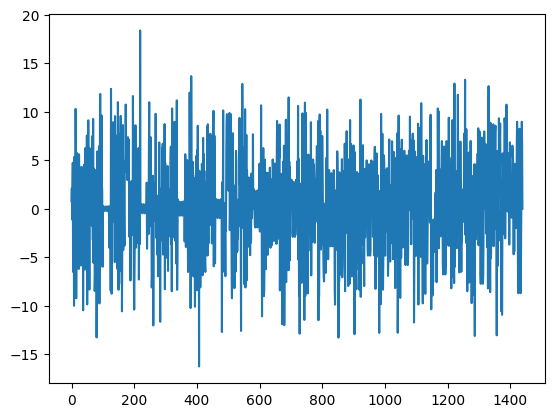

In [45]:
# create array of randon noise
arr = np.zeros(100)
# create a sinewave 100 points long
x = np.linspace(0, 5*np.pi, 20)
sin_y = np.sin(x)
# combine arrays into a single array
same_arr = np.concatenate((np.zeros(100)+np.random.normal(0, 5,100), sin_y, np.zeros(100)+np.random.normal(0, 5,100), sin_y, np.zeros(100)+np.random.normal(0, 5,100), sin_y), axis=0)
single_chain_1 = np.concatenate((np.zeros(100)+np.random.normal(0, 5,100), 0.25*sin_y, np.zeros(100)+np.random.normal(0, 5,100), 0.5*sin_y, np.zeros(100)+np.random.normal(0, 5,100), 0.75*sin_y))
single_chain_2 = np.concatenate((np.zeros(100)+np.random.normal(0, 5,100), sin_y, np.zeros(100)+np.random.normal(0, 5,100), 2*sin_y, np.zeros(100)+np.random.normal(0, 5,100), 3*sin_y))
single_chain_3 = np.concatenate((np.zeros(100)+np.random.normal(0, 5,100), 4*sin_y, np.zeros(100)+np.random.normal(0, 5,100), 5*sin_y, np.zeros(100)+np.random.normal(0, 5,100), 6*sin_y))
signle_chain_4 = np.concatenate((np.zeros(100)+np.random.normal(0, 5,100), 7*sin_y, np.zeros(100)+np.random.normal(0, 5,100), 8*sin_y, np.zeros(100)+np.random.normal(0, 5,100), 9*sin_y))
chain_arr_1=np.concatenate(10*(np.zeros(100)+np.random.normal(0, 5,100), 0.25*sin_y, np.random.rand(100), 0.5*sin_y, np.zeros(100)+np.random.normal(0, 5,100), 0.75*sin_y), axis=0)
long_chain = np.concatenate((single_chain_1,single_chain_2, single_chain_3, signle_chain_4), axis=0)


plt.plot(long_chain)
long_chain.shape

In [46]:
list_of_same_chain = [chain_arr_1 for i in range(10)]
list_w_noise = [arr + np.random.normal(0, 0.5, arr.shape) for arr in list_of_same_chain]

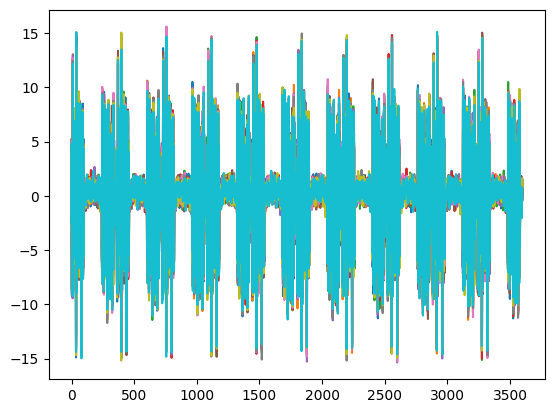

In [47]:
for l in list_w_noise:
    plt.plot(l)

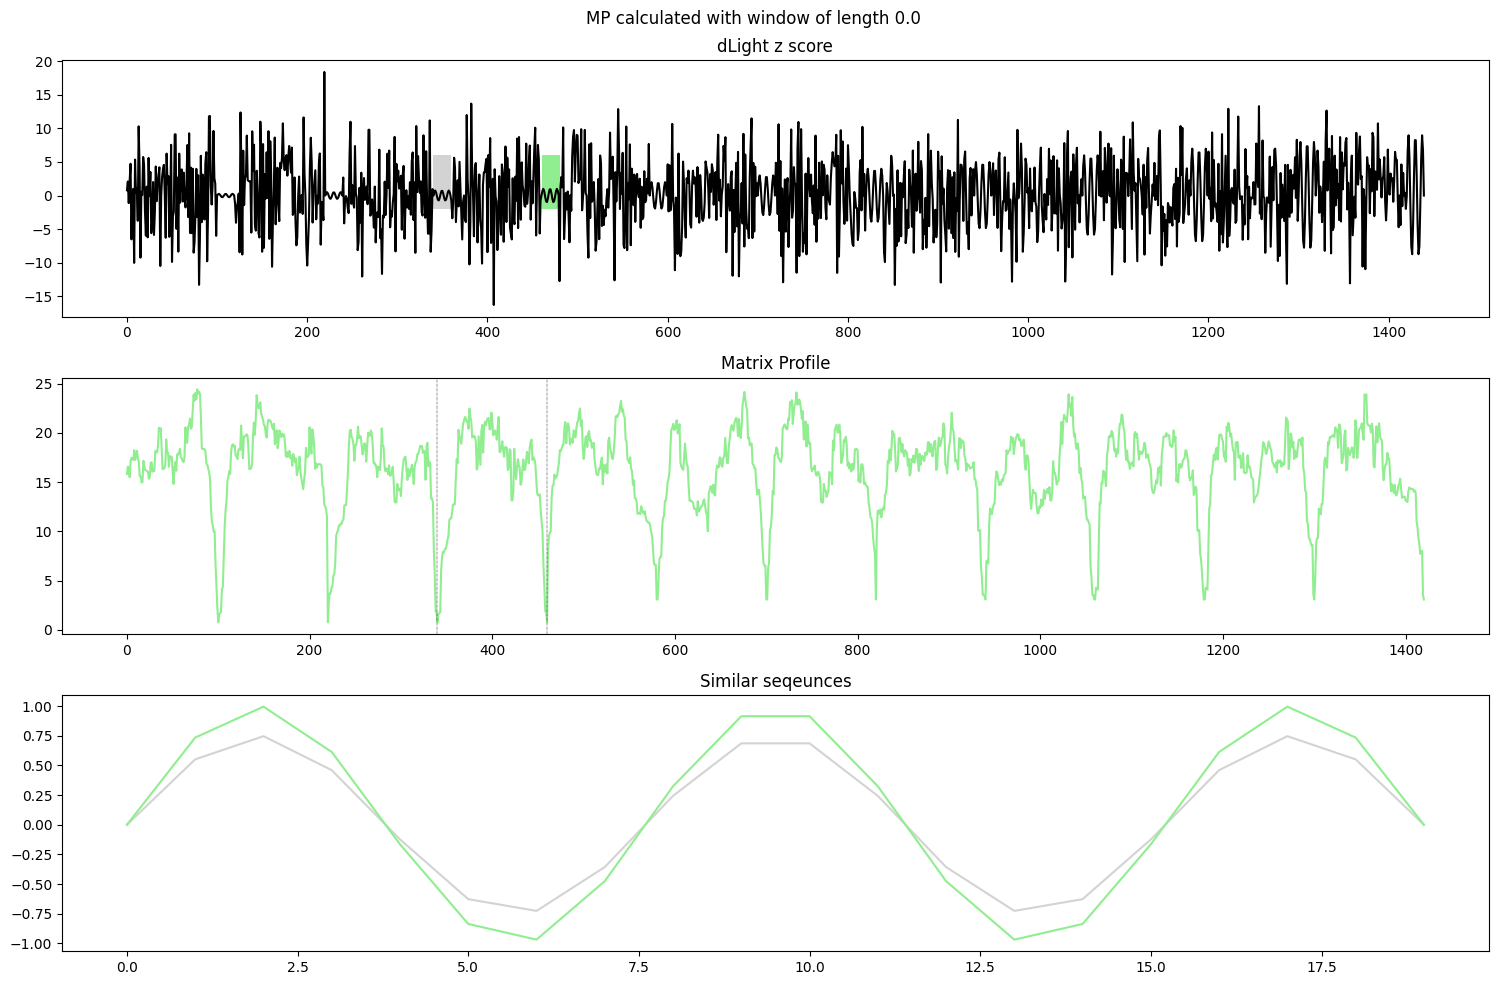

In [87]:
m = sin_y.shape[0]
profiler = MatrixProfiler(data = long_chain, m=m)
profiler.compute_profile()
profiler.compute_motifs()
profiler.plot_motifs()

In [88]:
profiler.mp

array([[15.832554328166044, 113, -1, 113],
       [16.56845584915395, 756, -1, 756],
       [16.16005416594211, 24, -1, 24],
       ...,
       [8.036126559375003, 1178, 1178, -1],
       [3.5623544242947878, 1299, 1299, -1],
       [3.0822070014843863, 1300, 1300, -1]], dtype=object)

In [100]:
mp = profiler.mp
sorted_distance_idx = np.argsort(mp[:,0])[:13]

mp[sorted_distance_idx]

array([[0.7705517503709399, 460, 220, 460],
       [0.7705517503709399, 340, 340, 580],
       [0.7705517503713065, 340, 100, 340],
       [0.7705517503714171, 220, 94, 220],
       [1.598773574316494, 101, 101, 460],
       [1.598773574316494, 341, 95, 341],
       [1.691851689491506, 102, 102, 460],
       [1.691851689491506, 342, 96, 342],
       [1.8036189121098551, 459, 220, 459],
       [1.8036189121098551, 339, 339, 580],
       [1.8322991774948094, 343, 97, 343],
       [1.8322991774948094, 103, 103, 460],
       [1.864205841003009, 338, 338, 698]], dtype=object)

In [86]:
mp

array([[-1, 15.832554328166044, 113, 113],
       [-1, 16.56845584915395, 756, 756],
       [-1, 16.16005416594211, 24, 24],
       ...,
       [-1, 8.036126559375003, 1178, 1178],
       [-1, 3.5623544242947878, 1299, 1299],
       [-1, 3.0822070014843863, 1300, 1300]], dtype=object)

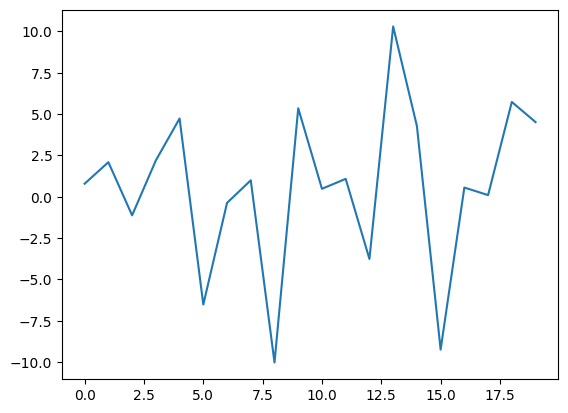

In [81]:

plt.plot(long_chain[sorted_distance_idx[0]:sorted_distance_idx[0]+m])


In [65]:
mp = profiler.mp[:,0
mp_mean = np.mean(mp)
st_dev = np.std(mp)
threshold = mp_mean-(2*st_dev)
print(f'mean {mp_mean} st_dev {st_dev} threshold {threshold}')



mean 16.299226561883142 st_dev 4.30485127016492 threshold 7.689524021553302


(array([  97,   98,   99,  100,  101,  102,  103,  104,  105,  106,  220,
         221,  222,  223,  224,  225,  226,  227,  228,  337,  338,  339,
         340,  341,  342,  343,  344,  345,  456,  457,  458,  459,  460,
         577,  578,  579,  580,  581,  582,  583,  584,  585,  697,  698,
         699,  700,  701,  702,  703,  819,  820,  935,  936,  937,  938,
         939,  940,  941,  942,  943, 1055, 1056, 1057, 1058, 1059, 1060,
        1061, 1062, 1063, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183,
        1299, 1300, 1301, 1419, 1420]),)

NameError: name 'unanchored_chain' is not defined

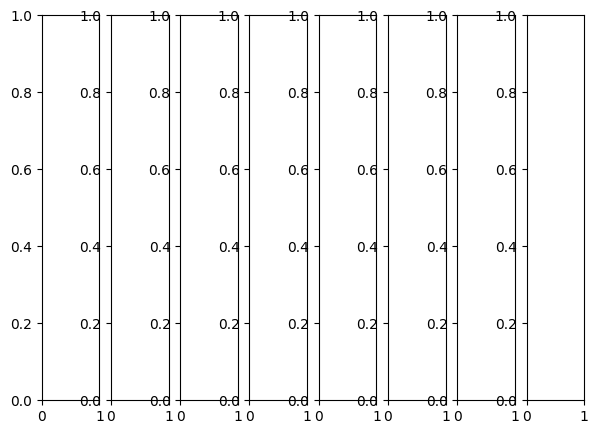

In [49]:

fig, ax = plt.subplots(ncols = 8, figsize = (7, 5))
for i in range(unanchored_chain.shape[0]):
    y = long_chain[unanchored_chain[i]: unanchored_chain[i]+m]
    x = np.arange(unanchored_chain[i], unanchored_chain[i]+ m)
    ax[i].plot(y, color = c)
    ax[i].set_title(f'Sequence {i+1}')
    sns.despine(left = True, right = True, bottom=True)
    
    # set y axis range
    ax[i].set_ylim(-2,10)
    ax[i].axis('off')
plt.tight_layout()

In [50]:
conserved_motifs = stumpy.ostinato(list_of_same_chain, m = m)

/Users/mds8301/anaconda3/envs/transphorm12/lib/python3.12/site-packages/stumpy/core.py:3684: UserWarning: Arrays T_A, T_B are equal, which implies a self-join. Try setting `ignore_trivial = True`.
  warnings.warn(msg)
/Users/mds8301/anaconda3/envs/transphorm12/lib/python3.12/site-packages/stumpy/core.py:3453: UserWarning: A large number of values in `P` are smaller than 1e-06.
For a self-join, try setting `ignore_trivial=True`.
  warnings.warn(msg)


In [51]:
radius, Ts_idx, subseq_idx = conserved_motifs
cms = list_of_same_chain[Ts_idx][subseq_idx: subseq_idx+m]
cms

array([ 3.67861955e-01,  4.98292247e-01,  3.07106356e-01, -8.22972951e-02,
       -4.18583239e-01, -4.84700133e-01, -2.37973697e-01,  1.62349735e-01,
        4.57886663e-01,  4.57886663e-01,  1.62349735e-01, -2.37973697e-01,
       -4.84700133e-01, -4.18583239e-01, -8.22972951e-02,  3.07106356e-01,
        4.98292247e-01,  3.67861955e-01,  3.06161700e-16, -5.71401807e-01])

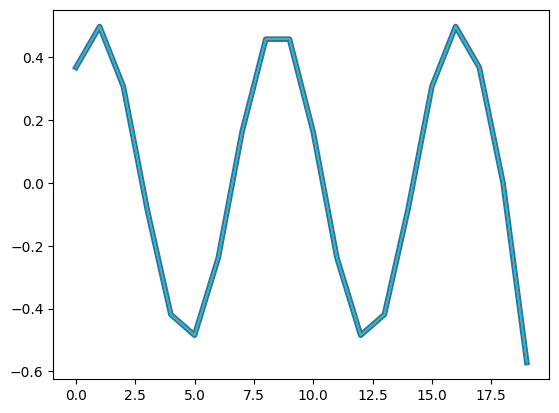

In [52]:
nn_idx = []
for i, T in enumerate(list_of_same_chain):
    nn_idx.append(np.argmin(stumpy.core.mass(cms, T)))
    lw = 1
    label = None
    if i ==Ts_idx:
        lw = 4
        label = 'Consensus Motif'
    plt.plot(T[nn_idx[i]: nn_idx[i]+m], lw = lw, label = label)